# Noise2Void - 3D Example for ExASPIM

In [1]:
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from matplotlib import pyplot as plt
import urllib
import zipfile
import zarr
import numpy as np
import dask.array as da
from distributed import Client
from csbdeep.utils import plot_history

from n2v.models import N2VConfig, N2V
from n2v.utils.n2v_utils import manipulate_val_data
from n2v.internals.N2V_DataGenerator import N2V_DataGenerator

2024-10-22 17:15:37.771082: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-22 17:15:37.890616: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Training Data Preparation
For training we will load a set of volumes taken from an ExASPIM brain (706301)

In [3]:
client = Client()

In [4]:
data_dir = "/data/exaSPIM_706301_training_blocks"

arrays = []
for block_dir in os.listdir(data_dir):
    if not "block_" in block_dir:
        continue
    zarr_path = os.path.join(data_dir, block_dir, f"{block_dir}.zarr")
    print(zarr_path)
    z = da.from_zarr(zarr_path, "0", chunks=(1,1,256,256,256)).squeeze().compute()
    z = z[np.newaxis, ..., np.newaxis]
    print(z.shape)
    arrays.append(z)

/data/exaSPIM_706301_training_blocks/block_000/block_000.zarr
(1, 1024, 1024, 1024, 1)
/data/exaSPIM_706301_training_blocks/block_001/block_001.zarr
(1, 1024, 1024, 1024, 1)
/data/exaSPIM_706301_training_blocks/block_002/block_002.zarr
(1, 1024, 1024, 1024, 1)
/data/exaSPIM_706301_training_blocks/block_003/block_003.zarr
(1, 1024, 1024, 1024, 1)
/data/exaSPIM_706301_training_blocks/block_004/block_004.zarr
(1, 1024, 1024, 1024, 1)
/data/exaSPIM_706301_training_blocks/block_005/block_005.zarr
(1, 1024, 1024, 1024, 1)
/data/exaSPIM_706301_training_blocks/block_006/block_006.zarr
(1, 1024, 1024, 1024, 1)


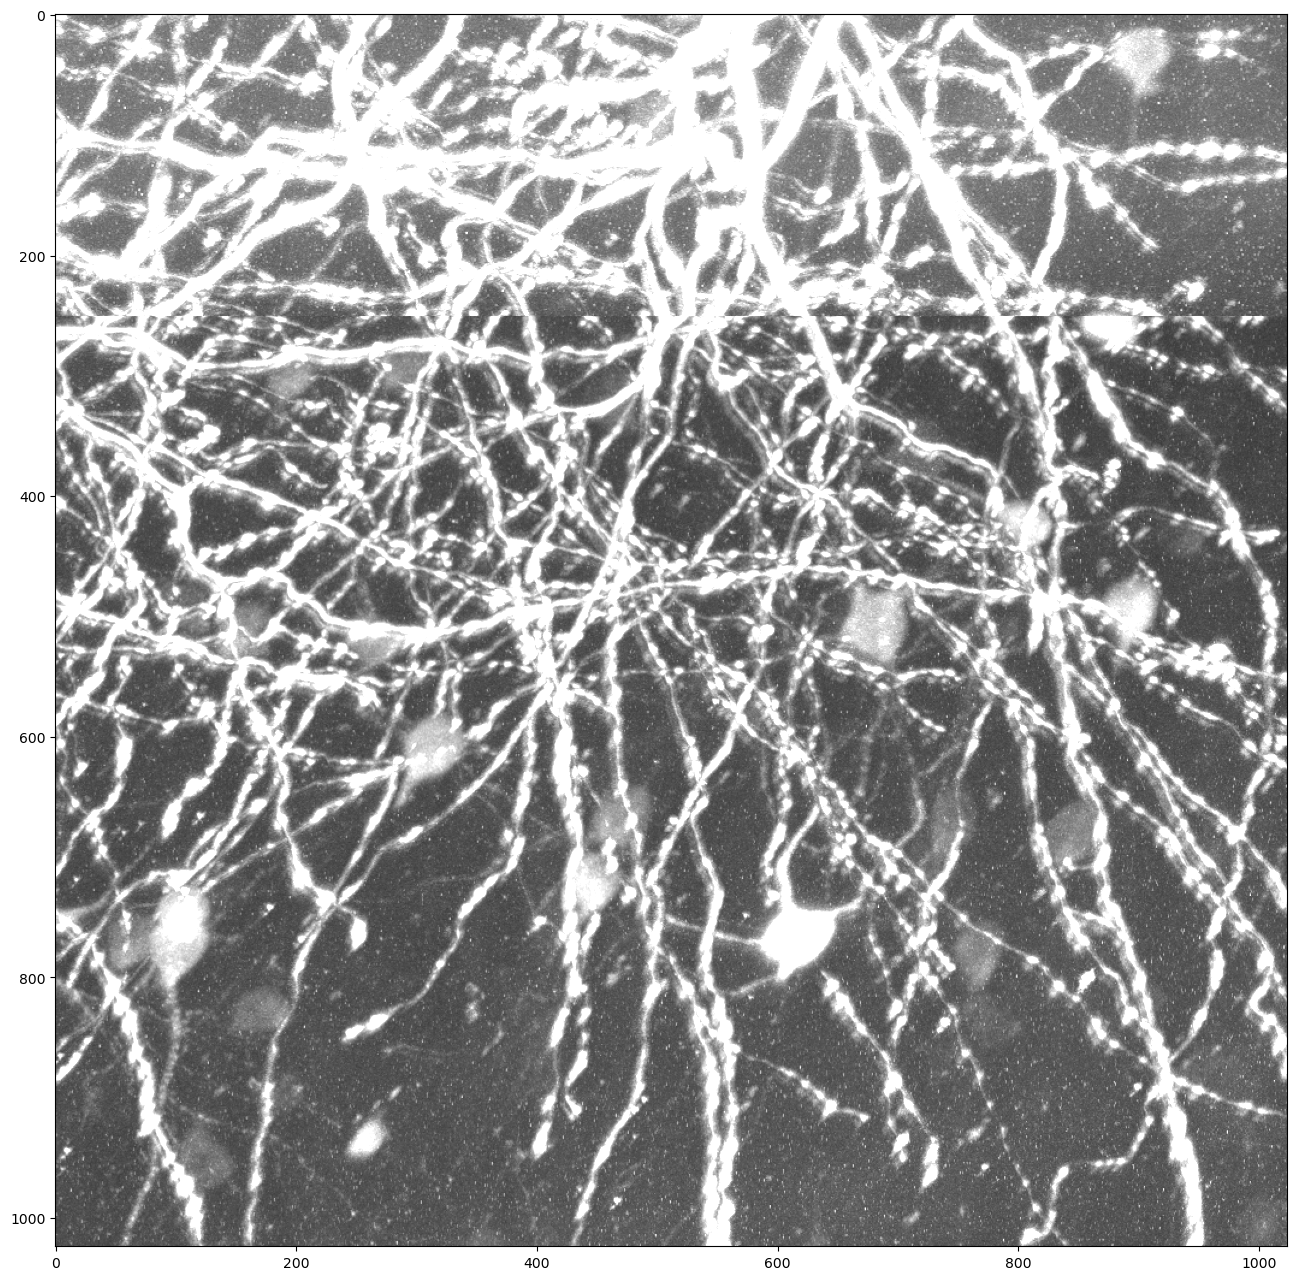

In [5]:
# Let's look at a maximum projection of the volume.
# We have to remove the added extra dimensions to display it.
plt.figure(figsize=(32,16))
plt.imshow(np.max(arrays[0][0,...,0],axis=0), 
           cmap='gray',
           vmin=np.percentile(arrays[0],0.1),
           vmax=np.percentile(arrays[0],99.9)
          )
plt.show()

In [6]:
# We create our DataGenerator-object.
# It will help us load data and extract patches for training and validation.
datagen = N2V_DataGenerator()

# Here we extract patches for training and validation.
patch_shape = (32, 64, 64)
patches = datagen.generate_patches_from_list(arrays, shape=patch_shape, num_patches_per_img=2000, shuffle=True, augment=False)

Generated patches: (2000, 32, 64, 64, 1)
Generated patches: (2000, 32, 64, 64, 1)
Generated patches: (2000, 32, 64, 64, 1)
Generated patches: (2000, 32, 64, 64, 1)
Generated patches: (2000, 32, 64, 64, 1)
Generated patches: (2000, 32, 64, 64, 1)
Generated patches: (2000, 32, 64, 64, 1)


In [7]:
# Patches are created so they do not overlap.
# (Note: this is not the case if you specify a number of patches. See the docstring for details!)
# Non-overlapping patches enable us to split them into a training and validation set.
X = patches[:8000]
X_val = patches[8000:]

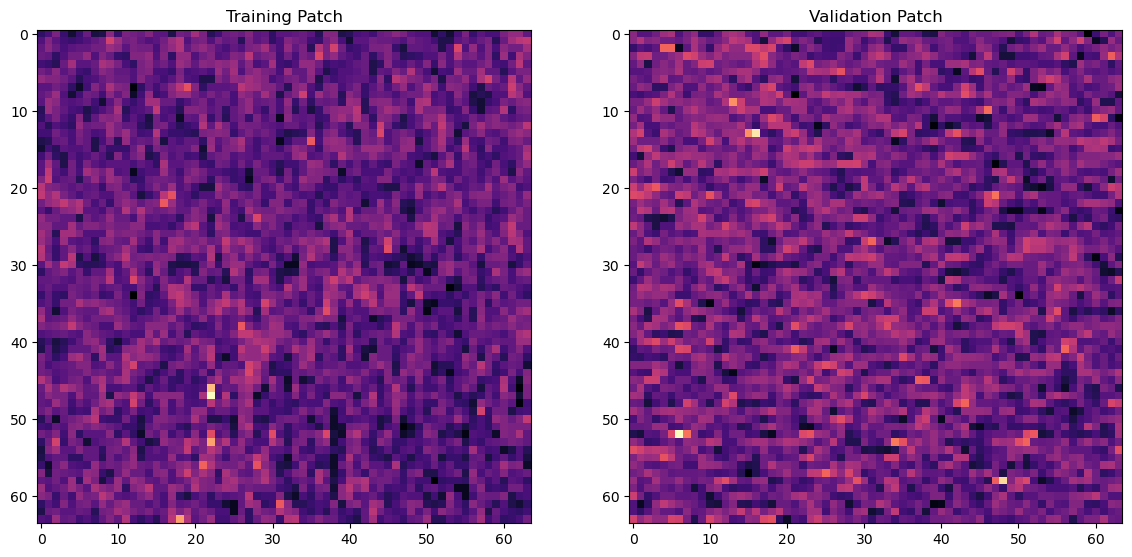

In [8]:
# Let's look at two patches.
plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.imshow(X[0,16,...,0],cmap='magma')
plt.title('Training Patch');
plt.subplot(1,2,2)
plt.imshow(X_val[0,16,...,0],cmap='magma')
plt.title('Validation Patch');

## Configure
Noise2Void comes with a special config-object, where we store network-architecture and training specific parameters. See the docstring of the <code>N2VConfig</code> constructor for a description of all parameters.

When creating the config-object, we provide the training data <code>X</code>. From <code>X</code> we extract <code>mean</code> and <code>std</code> that will be used to normalize all data before it is processed by the network. We also extract the dimensionality and number of channels from <code>X</code>.

Compared to supervised training (i.e. traditional CARE), we recommend to use N2V with an increased <code>train_batch_size</code> and <code>batch_norm</code>.
To keep the network from learning the identity we have to manipulate the input pixels during training. For this we have the parameter <code>n2v_manipulator</code> with default value <code>'uniform_withCP'</code>. Most pixel manipulators will compute the replacement value based on a neighborhood. With <code>n2v_neighborhood_radius</code> we can control its size. 

Other pixel manipulators:
* normal_withoutCP: samples the neighborhood according to a normal gaussian distribution, but without the center pixel
* normal_additive: adds a random number to the original pixel value. The random number is sampled from a gaussian distribution with zero-mean and sigma = <code>n2v_neighborhood_radius</code>
* normal_fitted: uses a random value from a gaussian normal distribution with mean equal to the mean of the neighborhood and standard deviation equal to the standard deviation of the neighborhood.
* identity: performs no pixel manipulation

For faster training multiple pixels per input patch can be manipulated. In our experiments we manipulated about 0.198% of the input pixels per patch. For a patch size of 64 by 64 pixels this corresponds to about 8 pixels. This fraction can be tuned via <code>n2v_perc_pix</code>.

For Noise2Void training it is possible to pass arbitrarily large patches to the training method. From these patches random subpatches of size <code>n2v_patch_shape</code> are extracted during training. Default patch shape is set to (64, 64), but since this is an 3D example we obviously need to specify a triple, here (32, 64, 64).  

In the past we experienced bleedthrough artifacts between channels if training was terminated to early. To counter bleedthrough we added the `single_net_per_channel` option, which is turned on by default. In the back a single U-Net for each channel is created and trained independently, thereby removing the possiblity of bleedthrough. <br/>
__Note:__ Essentially the network gets multiplied by the number of channels, which increases the memory requirements. If your GPU gets too small, you can always split the channels manually and train a network for each channel one after another.

<font color='red'>Warning:</font> to make this example notebook execute faster, we have set <code>train_epochs</code> to only 20. <br>For better results we suggest 100 to 200 <code>train_epochs</code>.

In [9]:
# You can increase "train_steps_per_epoch" to get even better results at the price of longer computation. 
config = N2VConfig(X, unet_kern_size=3, 
                   train_steps_per_epoch=int(X.shape[0]/128),train_epochs=200, train_loss='mse', batch_norm=True, 
                   train_batch_size=4, n2v_perc_pix=0.198, n2v_patch_shape=(32, 64, 64), 
                   n2v_manipulator='uniform_withCP', n2v_neighborhood_radius=5)

# Let's look at the parameters stored in the config-object.
vars(config)

{'means': ['27.975697566986085'],
 'stds': ['45.5070457559757'],
 'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 1,
 'unet_residual': False,
 'unet_n_depth': 2,
 'unet_kern_size': 3,
 'unet_n_first': 32,
 'unet_last_activation': 'linear',
 'unet_input_shape': (None, None, None, 1),
 'train_loss': 'mse',
 'train_epochs': 200,
 'train_steps_per_epoch': 62,
 'train_learning_rate': 0.0004,
 'train_batch_size': 4,
 'train_tensorboard': True,
 'train_checkpoint': 'weights_best.h5',
 'train_reduce_lr': {'factor': 0.5, 'patience': 10},
 'batch_norm': True,
 'n2v_perc_pix': 0.198,
 'n2v_patch_shape': (32, 64, 64),
 'n2v_manipulator': 'uniform_withCP',
 'n2v_neighborhood_radius': 5,
 'single_net_per_channel': True,
 'blurpool': False,
 'skip_skipone': False,
 'structN2Vmask': None,
 'probabilistic': False}

In [10]:
# a name used to identify the model
model_name = 'n2v_3D'
# the base directory in which our model will live
basedir = 'models'

# Load best checkpoint for re-training
model = N2V(config=config, name=model_name, basedir=basedir)

/n2v/n2v/models/n2v_standard.py:447: UserWarning: output path for model already exists, files may be overwritten: /root/capsule/code/n2v/examples/3D/models/n2v_3D
  warnings.warn(
2024-10-22 17:17:43.469534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-22 17:17:43.508630: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-22 17:17:43.511488: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-22 17:17:43.515273: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with

## Training

In [11]:
history = model.train(X, X_val)

259 blind-spots will be generated per training patch of size (32, 64, 64).


Preparing validation data: 100%|██████████| 6000/6000 [00:03<00:00, 1854.87it/s]


Epoch 1/200


2024-10-22 17:18:04.155401: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8801
2024-10-22 17:18:06.752454: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fb642b39a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-22 17:18:06.752473: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-22 17:18:06.757669: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-22 17:18:06.873322: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


62/62 [==============================] - 134s 2s/step - loss: 0.6986 - n2v_mse: 0.6986 - n2v_abs: 0.3470 - val_loss: 1.9529 - val_n2v_mse: 1.9599 - val_n2v_abs: 0.1994 - lr: 4.0000e-04
Epoch 2/200
62/62 [==============================] - 108s 2s/step - loss: 1.5584 - n2v_mse: 1.5584 - n2v_abs: 0.2546 - val_loss: 1.7039 - val_n2v_mse: 1.7082 - val_n2v_abs: 0.2327 - lr: 4.0000e-04
Epoch 3/200
62/62 [==============================] - 108s 2s/step - loss: 0.1738 - n2v_mse: 0.1738 - n2v_abs: 0.1779 - val_loss: 1.0754 - val_n2v_mse: 1.0759 - val_n2v_abs: 0.1773 - lr: 4.0000e-04
Epoch 4/200
62/62 [==============================] - 108s 2s/step - loss: 0.3430 - n2v_mse: 0.3430 - n2v_abs: 0.1780 - val_loss: 1.1292 - val_n2v_mse: 1.1314 - val_n2v_abs: 0.1736 - lr: 4.0000e-04
Epoch 5/200
62/62 [==============================] - 108s 2s/step - loss: 0.1409 - n2v_mse: 0.1409 - n2v_abs: 0.1742 - val_loss: 0.6862 - val_n2v_mse: 0.6928 - val_n2v_abs: 0.1984 - lr: 4.0000e-04
Epoch 6/200
62/62 [========

### After training, lets plot training and validation loss.

['loss', 'lr', 'n2v_abs', 'n2v_mse', 'val_loss', 'val_n2v_abs', 'val_n2v_mse']


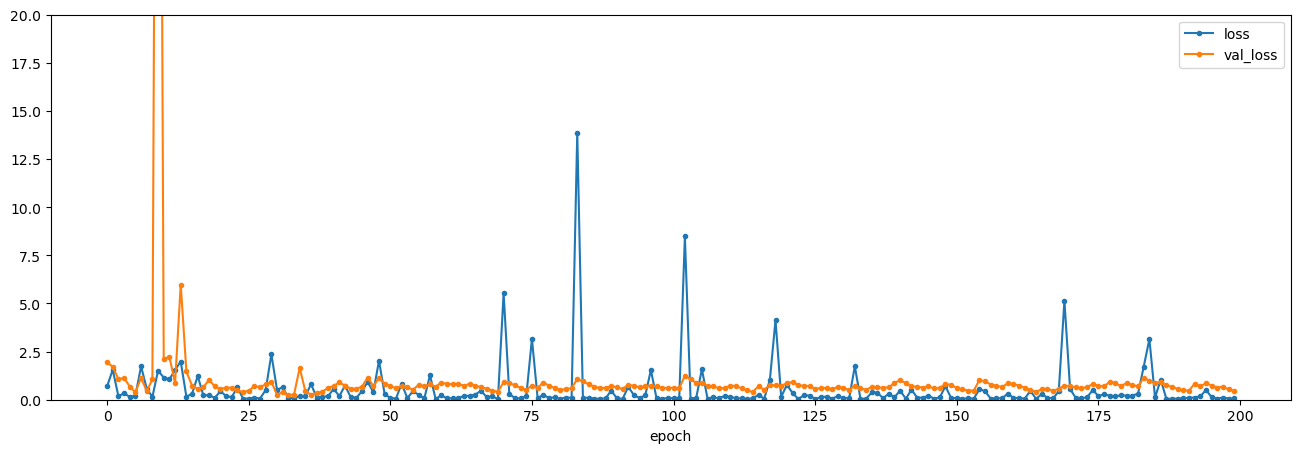

In [15]:
print(sorted(list(history.history.keys())))
plt.figure(figsize=(16,5))
plt.ylim(0,20)
plot_history(history,['loss','val_loss']);


## Export Model in BioImage ModelZoo Format
See https://imagej.net/N2V#Prediction for details.

In [13]:
model.export_TF(name='Noise2Void - ExASPIM Test', 
                description='This is the 3D Noise2Void model trained on ExASPIM data.', 
                authors=["Cameron Arshadi"],
                test_img=X_val[0,...], axes='ZYXC',
                patch_shape=patch_shape)

1/1 [==============================] - 0s 313ms/step


INFO:tensorflow:Assets written to: /root/capsule/code/n2v/examples/3D/models/n2v_3D/tf_model/assets


INFO:tensorflow:Assets written to: /root/capsule/code/n2v/examples/3D/models/n2v_3D/tf_model/assets
/opt/conda/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /tmp/root/bioimageio_cache/https/raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json. Skipping download of https://raw.githubusercontent.com/bioimage-io/bioimage.io/main/site.config.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)
/opt/conda/lib/python3.10/site-packages/bioimageio/spec/shared/_resolve_source.py:440: CacheWarning: found cached /tmp/root/bioimageio_cache/https/bioimage-io.github.io/collection-bioimage-io/collection.json. Skipping download of https://bioimage-io.github.io/collection-bioimage-io/collection.json.
  warnings.warn(f"found cached {local_path}. Skipping download of {uri}.", category=CacheWarning)



Model exported in BioImage ModelZoo format:
/root/capsule/code/n2v/examples/3D/models/n2v_3D/n2v_3D.bioimage.io.zip


/opt/conda/lib/python3.10/site-packages/bioimageio/spec/shared/schema.py:46: ValidationWarning: tags: Missing tags corresponding to bioimage.io categories: [{'modality': ['electron-microscopy', 'cryo-electron-microscopy', 'fluorescence-light-microscopy', 'transmission-light-microscopy', 'super-resolution-microscopy', 'x-ray-microscopy', 'force-microscopy', 'high-content-imaging', 'whole-slide-imaging', 'other']}, {'content': ['cells', 'nuclei', 'extracellular-vesicles', 'tissue', 'plant', 'mitochondria', 'vasculature', 'cell-membrane', 'brain', 'whole-organism']}, {'method': ['stardist', 'cellpose', 'yolo', 'care', 'n2v', 'denoiseg']}]
  warnings.warn(msg, category=ValidationWarning)
